In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm

%matplotlib inline

### Task:

During testing of one hypothesis, the target group was offered a new mechanism for paying for services on the site, while the control group remained with the basic mechanics. As a task, you need to analyze the results of the experiment and decide whether it is worth launching a new payment mechanism for all users.

### Questions I need to answer:

1. What metrics do you look at during the analysis and why?
2. Are there differences in performance and what might they be related to?
3. Are these differences statistically significant?
4. Is it worth launching new mechanics for all users?

In [2]:
# Uploading data

groups = pd.read_csv('data/groups.csv', sep=';')
groups_add = pd.read_csv('data/group_add.csv')
active_studs = pd.read_csv('data/active_studs.csv')
checks = pd.read_csv('data/checks.csv', sep=';')

* Let's check if the data uploaded correctly and if there are NaN values

In [3]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [5]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [6]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


*We can see that types of the columns are correct and there are no NaN values*

* Let's concatente DataFrames **groups** and **groups_add** and rename columns

In [7]:
groups = pd.concat([groups, groups_add]).reset_index(drop=True) \
           .rename(columns={'id': 'student_id', 'grp': 'group'})

In [8]:
groups.head()

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


* Creating single DataFrame with data about groups, activity and purchases

In [9]:
# Let's put DataFrame with active users groups into variable 'users'

users = groups.merge(active_studs, on='student_id', how='inner')

In [10]:
# Let's check if the number of users in active_studs is equal to number of users in users
# to be shure we didn't loose some data

active_studs.shape[0] == len(users)

True

In [11]:
# Adding to DataFrame with users purchase data

users = users.merge(checks, on='student_id', how='left')

In [12]:
# Let's check if all of the purchase data are in 'users' DataFrame

checks.student_id.nunique() == users.rev.count()

False

*We see that not all of purchased users were active. Let's find who we've lost*

In [13]:
checks.query('student_id not in @users.student_id')

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


*We can see there are 149 users had purchase during A/B test, but they were not active. I think those users didn't use the mechanism we are testing becouse they didn't use our website (were not active). Maybe it was automaticly payment (like monthly payment). That's why, I wount include thouse users to our test.*

In [14]:
# Adding column with status (was payment or not)

users['has_payment'] = users.rev.apply(lambda x: x > 0)

In [15]:
users.head()

,student_id,group,rev,has_payment
0,1627,A,990.0,True
1,2085,B,NaN,False
2,2215,B,NaN,False
3,3391,A,NaN,False
4,3401,B,NaN,False


#### Calculating metrics ARPU, AOV, CR

In [16]:
# Let's group data by the groups

grouped_data = users.groupby('group', as_index=False) \
                    .agg({'student_id': 'count', 'rev': 'sum', 'has_payment': 'sum'}) \
                    .rename(columns={'student_id': 'number_of_students', 'has_payment': 'purchases', \
                                     'rev': 'revenue'})

# Calculatig metrics we need

grouped_data['ARPU'] = grouped_data.revenue / grouped_data.number_of_students
grouped_data['AOV'] = grouped_data.revenue / grouped_data.purchases
grouped_data['CR'] = grouped_data.purchases / grouped_data.number_of_students

In [17]:
grouped_data

,group,number_of_students,revenue,purchases,ARPU,AOV,CR
0,A,1538,72820.0000,78,47.347204,933.589744,0.050715
1,B,6803,394974.0035,314,58.058798,1257.878992,0.046156


*CR to purchase little lower in group B. But the AOV much higher in group B rather group A. It can be becouse of our new paying mechanism. I guess users in group B can prefer higher price services then users in group A. Also I can see that ARPU in group B higher then group A. It is also can be becouse our new paying mechanism.*

#### To check if CR differences statistically significant let's use chi-squared test

In [18]:
# Preparing the data

cross_t = pd.crosstab(users.group, users.has_payment)

In [19]:
cross_t

has_payment,False,True
group,,
A,1460,78
B,6489,314


In [20]:
# apply the test

chi2, p, dof, expected = stats.chi2_contingency(cross_t)

print(f"chi2 statistic:     {chi2:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)

chi2 statistic:     0.48481
p-value:            0.48625
degrees of freedom: 1
expected frequencies:
[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


*We can see that **p-value** is **0.486** mean that we can't say **CR** differences statistically significant*

#### Let's see the distribution of AOV

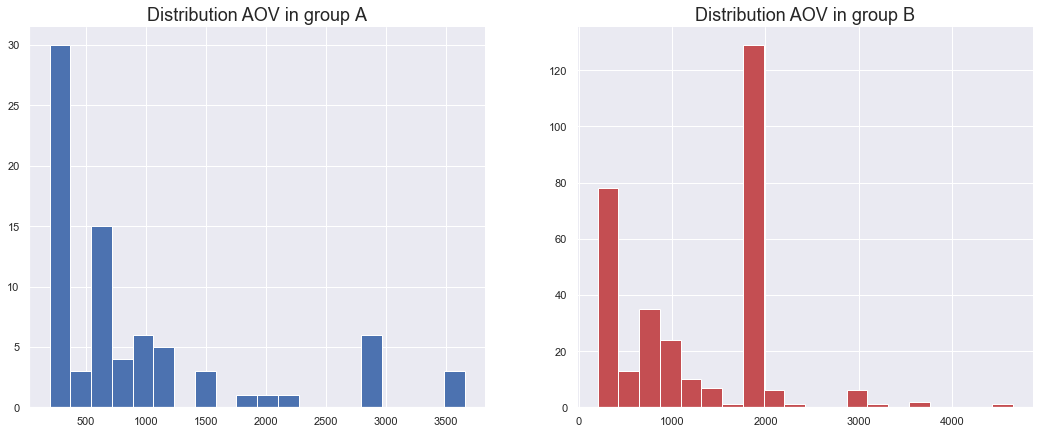

In [21]:
# Set general parameters

sns.set(
    style='darkgrid',
    rc={'figure.figsize': (18, 7)})


# Drow first plot

plt.subplot(1, 2, 1)
plt.title('Distribution AOV in group А', fontsize=18)
users[users.group == 'A'].rev.hist(bins=20, color='b')


# Drow second plot

plt.subplot(1, 2, 2)
plt.title('Distribution AOV in group B', fontsize=18)
users[users.group == 'B'].rev.hist(bins=20, color='r')

sns.despine()

*We see that in group B there are a lot of payments with value around 2000*

*Also we can see that the distributions don't look normal. But that may be becouse there are not enough data (only 78 purchases in group A and 314 in group B). I think  the best test to use in this case is bootstrap*

In [22]:
# Createing function to check hypothesis with bootstrap

def get_bootstrap(
    data_column_1, # firts sample values
    data_column_2, # second sample values
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # statistics we need
    bootstrap_conf_level = 0.95 # confidence level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # taking subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # using statistic function
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

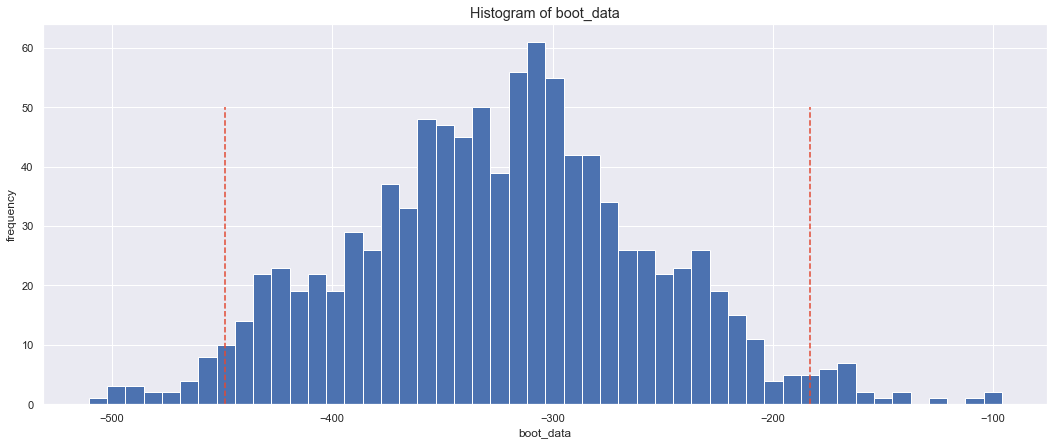

In [23]:
bootstrap_data = get_bootstrap(users.query('group == "A" and rev > 0').rev, 
                               users.query('group == "B" and rev > 0').rev,
                              boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95)

In [24]:
print('p-value: ', bootstrap_data['p_value'])

p-value:  1.7841032761904842e-06


Because ***p-value*** is much lower then 0.05, we can say that the difference of ***AOV*** in groups A and B is statistically significant

### Conclusion:

During the experiment, we found that the difference between **AOV** in group *A* and *B* are statistically significant, which means that increase of **AOV** in group *B* by 324.3 is statistically significant. At the same time, the 0.45% decrease in **CR** is not statistically significant.

We can conclude that the new paying mechanism on the website does not affect the **CR**, while increasing the **AOV**.

I think that the new paying mechanism should be launched for all users, since it gives additional income.